<a href="https://colab.research.google.com/github/nosgueira/PLN-2022-1/blob/main/Atividade07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade 07 -  Classificação de Imagens de Documentos
- Gabriel da Silva Corvino Nogueira (180113330)

## Imports

In [19]:
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd

from keras.utils.np_utils import to_categorical

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Activation, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm.notebook import tqdm


## Baixar Dataset de Documentos escaneados

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/My Drive/full_3.zip", 'r')
zip_ref.extractall()
zip_ref.close()

Leitura de dados

In [3]:
path_documents ='/content/full_3' 
lista_subfolders = os.listdir(path_documents)


dataset_dict = {}
dataset_dict['filename'] = []
dataset_dict['label'] = []

for folder in lista_subfolders:
    lista_imagens = os.listdir(path_documents+'/'+folder)

    for img_file in lista_imagens:
        dataset_dict['filename'].append(path_documents+'/'+folder+'/'+img_file)
        dataset_dict['label'].append(folder)

In [4]:
df = pd.DataFrame(dataset_dict, columns= ['filename', 'label'])
df

,filename,label
0,/content/full_3/scientific _publication/250225...,scientific _publication
1,/content/full_3/scientific _publication/100469...,scientific _publication
2,/content/full_3/scientific _publication/204639...,scientific _publication
3,/content/full_3/scientific _publication/250535...,scientific _publication
4,/content/full_3/scientific _publication/250542...,scientific _publication
...,...,...
2956,/content/full_3/advertisement/2044905226.tif,advertisement
2957,/content/full_3/advertisement/2058504145.tif,advertisement
2958,/content/full_3/advertisement/91383464.tif,advertisement
2959,/content/full_3/advertisement/6132.tif,advertisement


## Divisão dos dados em treinamento, validação e teste

In [5]:
X = df['filename'].values
y = df['label'].values

In [6]:
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid,y_test = train_test_split(X_test, y_test, test_size=0.6, random_state=42)

Criação de logits:

In [7]:
from keras.utils.np_utils import to_categorical

y_train_logits = to_categorical(pd.Categorical(y_train).codes)
y_valid_logits = to_categorical(pd.Categorical(y_valid).codes)
y_test_logits = to_categorical(pd.Categorical(y_test).codes)

In [8]:
lista_train = list(zip(X_train, y_train))
lista_test  = list(zip(X_test, y_test))
lista_valid = list(zip(X_valid, y_valid))

In [9]:
df_train = pd.DataFrame(lista_train, columns=['filename', 'label'])
df_valid = pd.DataFrame(lista_valid, columns=['filename', 'label'])
df_test = pd.DataFrame(lista_test, columns=['filename', 'label'])

In [11]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(df_train,
                                             directory=path_documents,
                                             x_col='filename',
                                             y_col='label',
                                             class_mode='categorical',
                                             shuffle=True)

valid_generator = datagen.flow_from_dataframe(df_valid,
                                             directory=path_documents,
                                             x_col='filename',
                                             y_col='label',
                                             class_mode='categorical',
                                             shuffle=True)

test_generator = datagen.flow_from_dataframe(df_test,
                                             directory=path_documents,
                                             x_col='filename',
                                             y_col='label',
                                             class_mode='categorical',
                                             shuffle=True)

Found 2072 validated image filenames belonging to 3 classes.
Found 355 validated image filenames belonging to 3 classes.
Found 534 validated image filenames belonging to 3 classes.


## AlexNet (sem pré-treinamento)

In [12]:
dims = (224,224,3)
num_classes = 3

### Arquitetura

In [20]:
model_alexnet = Sequential()

model_alexnet.add(layers.experimental.preprocessing.Resizing(224,224,interpolation="bilinear",input_shape=(224,224,3)))
model_alexnet.add(Conv2D(96,(11,11), strides=(4,4)))
model_alexnet.add(Activation("relu"))
model_alexnet.add(MaxPooling2D((3, 3),strides=(2,2)))
model_alexnet.add(BatchNormalization())

model_alexnet.add(Conv2D(256,(5,5), strides=(1,1),padding="same"))
model_alexnet.add(Activation("relu"))
model_alexnet.add(MaxPooling2D((3, 3),strides=(2,2)))
model_alexnet.add(BatchNormalization())

model_alexnet.add(Conv2D(384,(3,3), strides=(1,1),padding="same"))
model_alexnet.add(Activation("relu"))
model_alexnet.add(BatchNormalization())

model_alexnet.add(Conv2D(384,(3,3), strides=(1,1),padding="same"))
model_alexnet.add(Activation("relu"))
model_alexnet.add(BatchNormalization())

model_alexnet.add(Conv2D(256,(3,3), strides=(1,1),padding="same"))
model_alexnet.add(Activation("relu"))
model_alexnet.add(MaxPooling2D((3, 3),strides=(2,2)))
model_alexnet.add(BatchNormalization())

model_alexnet.add(Flatten())
model_alexnet.add(Dense(4096))
model_alexnet.add(Activation("relu"))
model_alexnet.add(layers.Dropout(0.5))

model_alexnet.add(Dense(4096))
model_alexnet.add(Activation("relu"))
model_alexnet.add(layers.Dropout(0.5))

model_alexnet.add(Dense(num_classes))
model_alexnet.add(Activation("softmax"))

### Treinamento

In [21]:
sgd = SGD(lr=0.0001)
model_alexnet.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

model_alexnet.fit(train_generator,
                  epochs=20, batch_size=16, 
                  validation_data=valid_generator)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
65/65 [==============================] - 10s 151ms/step - loss: 1.0905 - accuracy: 0.5212 - val_loss: 1.1410 - val_accuracy: 0.3183
Epoch 2/20
65/65 [==============================] - 9s 146ms/step - loss: 0.7116 - accuracy: 0.7037 - val_loss: 1.2997 - val_accuracy: 0.3521
Epoch 3/20
65/65 [==============================] - 10s 159ms/step - loss: 0.6426 - accuracy: 0.7437 - val_loss: 1.4019 - val_accuracy: 0.3493
Epoch 4/20
65/65 [==============================] - 10s 148ms/step - loss: 0.5828 - accuracy: 0.7785 - val_loss: 1.5443 - val_accuracy: 0.3493
Epoch 5/20
65/65 [==============================] - 10s 147ms/step - loss: 0.5663 - accuracy: 0.7785 - val_loss: 1.2295 - val_accuracy: 0.3606
Epoch 6/20
65/65 [==============================] - 10s 147ms/step - loss: 0.5409 - accuracy: 0.7891 - val_loss: 1.0637 - val_accuracy: 0.4423
Epoch 7/20
65/65 [==============================] - 11s 162ms/step - loss: 0.5292 - accuracy: 0.7968 - val_loss: 0.8049 - val_accuracy: 0.6225


Definindo função para mostrar funções de *loss*


In [24]:
def show_graph(model, name):
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.title(f'Model Loss - {name}')
    plt.xlabel('epoch')
    plt.legend(['training set','validation set'], loc='best')
    plt.show()

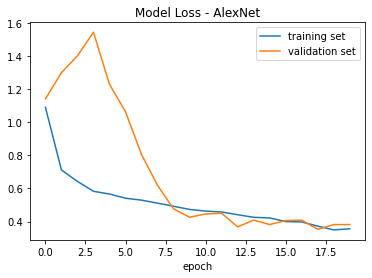

In [25]:
show_graph(model_alexnet, 'AlexNet')

### Teste


In [33]:
y_pred = np.argmax(model_alexnet.predict(test_generator), axis=1)

In [35]:
y_test = test_generator.classes

In [36]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.39      0.34      0.37       180
           1       0.34      0.32      0.33       170
           2       0.39      0.45      0.42       184

    accuracy                           0.37       534
   macro avg       0.37      0.37      0.37       534
weighted avg       0.37      0.37      0.37       534



## ResNet50 (sem pré-treinamento)

### Arquitetura

In [38]:
model_resnet1 = Sequential()
model_resnet_no_pt = ResNet50(input_shape=dims,
                              include_top=False,
                              pooling='avg',
                              weights=None,
                              classes=num_classes)
model_resnet1.add(model_resnet_no_pt)
model_resnet1.add(Flatten())
model_resnet1.add(Dense(4096))
model_resnet1.add(Activation("relu"))
model_resnet1.add(Dropout(0.5))

model_resnet1.add(Dense(num_classes))
model_resnet1.add(Activation("softmax"))


### Treinamento

In [39]:
sgd = SGD(lr=0.0001)

model_resnet1.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

model_resnet1.fit(train_generator,
          epochs=20,
          batch_size=16,
          validation_data=valid_generator)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


65/65 [==============================] - 50s 564ms/step - loss: 1.0486 - accuracy: 0.4788 - val_loss: 1.1100 - val_accuracy: 0.3493
Epoch 2/20
65/65 [==============================] - 31s 478ms/step - loss: 0.8364 - accuracy: 0.6211 - val_loss: 1.1884 - val_accuracy: 0.3493
Epoch 3/20
65/65 [==============================] - 30s 451ms/step - loss: 0.7690 - accuracy: 0.6540 - val_loss: 1.3543 - val_accuracy: 0.3493
Epoch 4/20
65/65 [==============================] - 31s 477ms/step - loss: 0.7145 - accuracy: 0.6993 - val_loss: 1.5457 - val_accuracy: 0.3493
Epoch 5/20
65/65 [==============================] - 34s 523ms/step - loss: 0.7201 - accuracy: 0.6897 - val_loss: 1.5687 - val_accuracy: 0.3493
Epoch 6/20
65/65 [==============================] - 29s 448ms/step - loss: 0.6829 - accuracy: 0.7075 - val_loss: 1.3469 - val_accuracy: 0.3493
Epoch 7/20
65/65 [==============================] - 30s 453ms/step - loss: 0.6617 - accuracy: 0.7312 - val_loss: 1.1519 - val_accuracy: 0.3606
Epoch 8/20

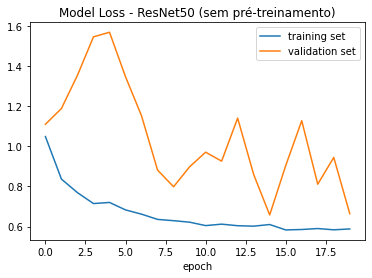

In [41]:
show_graph(model_resnet1, 'ResNet50 (sem pré-treinamento)')

### Teste

In [42]:
y_pred = np.argmax(model_resnet1.predict(test_generator), axis=1)
y_test = test_generator.classes
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.33      0.26      0.29       180
           1       0.32      0.24      0.28       170
           2       0.33      0.48      0.39       184

    accuracy                           0.33       534
   macro avg       0.33      0.33      0.32       534
weighted avg       0.33      0.33      0.32       534



## ResNet50 (com pré-treinamento a partir de transfer learning)

### Arquitetura

In [48]:
model_resnet2 = Sequential()
model_resnet_pt = ResNet50(input_shape=dims,
                           include_top=False,
                           pooling='avg',
                           weights='imagenet',
                           classes=num_classes )

for layer in model_resnet2.layers : layer.trainable=False

model_resnet2.add(model_resnet_pt)
model_resnet2.add(Flatten())
model_resnet2.add(Dense(4096))
model_resnet2.add(Activation('relu'))
model_resnet2.add(Dropout(0.5))

model_resnet2.add(Dense(num_classes))
model_resnet2.add(Activation("softmax"))

### Treinamento

In [49]:
sgd = SGD(lr=0.0001)

model_resnet2.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

model_resnet2.fit(train_generator,
          epochs=20,
          batch_size=16,
          validation_data=valid_generator)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
65/65 [==============================] - 38s 508ms/step - loss: 1.0436 - accuracy: 0.4759 - val_loss: 1.0608 - val_accuracy: 0.5662
Epoch 2/20
65/65 [==============================] - 32s 488ms/step - loss: 0.8864 - accuracy: 0.6086 - val_loss: 1.1823 - val_accuracy: 0.3437
Epoch 3/20
65/65 [==============================] - 29s 450ms/step - loss: 0.7866 - accuracy: 0.6868 - val_loss: 1.2635 - val_accuracy: 0.2479
Epoch 4/20
65/65 [==============================] - 30s 455ms/step - loss: 0.7046 - accuracy: 0.7437 - val_loss: 1.1981 - val_accuracy: 0.2873
Epoch 5/20
65/65 [==============================] - 30s 454ms/step - loss: 0.6352 - accuracy: 0.7867 - val_loss: 1.2234 - val_accuracy: 0.2901
Epoch 6/20
65/65 [==============================] - 29s 446ms/step - loss: 0.5851 - accuracy: 0.8098 - val_loss: 1.2091 - val_accuracy: 0.3211
Epoch 7/20
65/65 [==============================] - 29s 448ms/step - loss: 0.5427 - accuracy: 0.8147 - val_loss: 1.1891 - val_accuracy: 0.3577

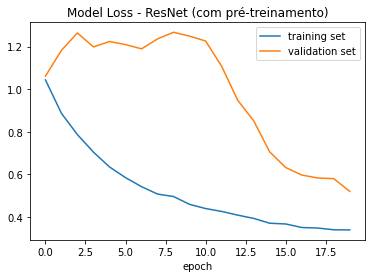

In [51]:
show_graph(model_resnet2, 'ResNet (com pré-treinamento)')

### Teste

In [50]:
y_pred = np.argmax(model_resnet1.predict(test_generator), axis=1)
y_test = test_generator.classes
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.40      0.34      0.37       180
           1       0.32      0.06      0.11       170
           2       0.36      0.68      0.48       184

    accuracy                           0.37       534
   macro avg       0.36      0.36      0.32       534
weighted avg       0.36      0.37      0.32       534



## Extração de caracteres em cada documento (treinamento, validação e testes)

- A Ferramenta **PyMuPDF** não pôde ser utilizada para extração pois apenas funciona com documentos do tipo PDF.
- A Ferramenta **Pytesserac**t não pode ser utilizada pois o binário `tesseract-ocr` deve estar instalado no sistema, o que não é possível fazer pelo colab
- Sendo assim, a ferramenda **Keras-OC**R foi utilizada, contudo, como sera demonstrado abaixo, o processo é demorado e não consegue ser terminado devido aos recursos disponíveis no ambiente do colab.


In [10]:
!pip install -q keras-ocr

In [11]:
import keras_ocr 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


### Extração de Texto de um Documento

In [12]:
image = [keras_ocr.tools.read("full_3/email/0024.tif")]

In [13]:
%%time
prediction_groups = pipeline.recognize(image)

CPU times: user 17.7 s, sys: 1.7 s, total: 19.4 s
Wall time: 28 s


In [14]:
words = []
for word, box in prediction_groups[0]:
    words.append(word)
print(' '.join(words))

froms petrec vickic m stokcs jim ellis john fish to david powcrss donald foreman frank lesicr henry singlcton john judy albert karl gallant m hurst marshall mikc phillips murray jonesi tompson mozingo sicvc srawsburg tommy randy roger paync cci bcca primary dates 711al 999 1835s am modified igggjulla 1a14s last dates last touched dates sent gggjul ja lls55 dates gygjulla 1is3155 received dates subject ta tma topline attachments tm07 lun doc s s rjrooooolini 886 70028 6617


### Extração de texto de todos os documentos

#### Treino

In [15]:
df_train

,filename,label
0,/content/full_3/email/2078712383.tif,email
1,/content/full_3/advertisement/2061001531.tif,advertisement
2,/content/full_3/scientific _publication/600467...,scientific _publication
3,/content/full_3/email/2071863518d_3519.tif,email
4,/content/full_3/email/2085315655.tif,email
...,...,...
2067,/content/full_3/email/2085272065.tif,email
2068,/content/full_3/email/2080891376a.tif,email
2069,/content/full_3/email/2064833034.tif,email
2070,/content/full_3/email/1041.tif,email


Primeiro, foi tentado extrair todos os dados de uma vez

In [ ]:
images = [keras_ocr.tools.read(file) for file in df_train.filename] 

Após a tentativa da execução do comando abaixo, o seguinte diagnóstico foi gerado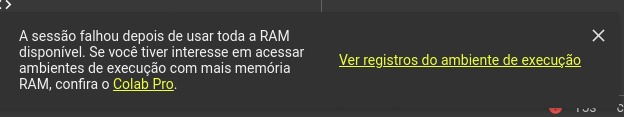:

In [ ]:
# %%time
# prediction_groups = pipeline.recognize(images)

Em seguida foi realizada a tentativa de separar o processo em batches, para não sobrecarregar o sistema. Porém, o seguinte erro acontece após mais de 30 minutos de execução.

In [22]:
texts = []
for i in tqdm(range(int(np.ceil(df_train.size/5)))):
    images = [keras_ocr.tools.read(file) for file in df_train.filename[i:i+5]]
    prediction_groups = pipeline.recognize(images)
    for predicted_image in prediction_groups:
        text = ' '.join([word for word, _ in predicted_image])
        texts.append(text)

  0%|          | 0/829 [00:00<?, ?it/s]

ResourceExhaustedError: ignored

Sendo assim não foi possível gerar os dataframes, por completo, mas segue um dataframe de treino parcial:

In [23]:
pd.DataFrame({'text': texts, 'label': df_train.label[:len(texts)]})

,text,label
0,2078712383 from marchesi tricia m tuesday janu...,email
1,nowi hlfi parliament is besth with recessed fi...,advertisement
2,5849 mycassociated a zinc finger protein bindi...,scientific _publication
3,e original messages henry froms femarndez l so...,email
4,2085315655 lipowicz peter j from lipowicz pele...,email
...,...,...
590,cohen denise a cohen denise a from 26 sent we...,email
591,review indoor built 199s76s66 indoor buil edvi...,scientific _publication
592,hkes1s dalm ajebar sp pl taslgo uita 2 fos the...,advertisement
593,2085115710 ostern eric from oslern eric sent m...,email
